# Predicting Box Office Revenue

In [847]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, ttest_ind, f_oneway
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data cleanup and Formatting

We start with the [TMDB 5000 movie dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata/data) from Kaggle. This dataset consists of 2 files with general movie data, and movie credit data for 5000 movies. This notebook assumes you have the 2 files downloaded to the root of this project directory.

First, we will join the two dataset files into a single dataframe. They are joined by movie id, and we drop duplicate columns that appear in both files. These leaves us with data for 4803 movies.

In [848]:
# Load the 2 data files
movies_data = pd.read_csv('../tmdb_5000_movies.csv')
credits_data = pd.read_csv('../tmdb_5000_credits.csv')

# Perform an inner join on the movies and credits data so it's all in one dataframe
all_movies_data = pd.merge(movies_data, credits_data, left_on='id', right_on='movie_id', how='inner', suffixes=('_movies', '_credits'))

# Drop duplicate id and title fields
all_movies_data = all_movies_data.drop(columns=['movie_id', 'title_credits'])
# Rename original title field
all_movies_data = all_movies_data.rename(columns={'title_movies': 'title'})

print('Movies remaining in dataset after merge: {}'.format(len(all_movies_data)))

Movies remaining in dataset after merge: 4803


Since revenue is our target, and budget is an important variable, we drop rows with no budget or revenue data. The remaining dataset is 3229 rows.

In [849]:
# Remove data with no revenue or budget info
all_movies_data = all_movies_data.dropna(subset=['budget', 'revenue'])
all_movies_data = all_movies_data[all_movies_data['budget'] > 0]
all_movies_data = all_movies_data[all_movies_data['revenue'] > 0]

print('Movies remaining in dataset after dropping rows without budget or revenue data: {}'.format(len(all_movies_data)))

Movies remaining in dataset after dropping rows without budget or revenue data: 3229


Next we remove upper bound revenue outliers, otherwise every result just suggests "Make an action movie with James Cameron".

To remove the outliers, we calculate the zscore for each movie's revenue, and only keep rows with a revenue zscore less than 3. This leaves us with 3146 movies.

In [850]:
all_movies_data['revenue_zscore'] = zscore(all_movies_data['revenue'])
all_movies_data = all_movies_data[all_movies_data['revenue_zscore'] <= 3]
print('Movies remaining in dataset after removing upper revenue outliers: {}'.format(len(all_movies_data)))

Movies remaining in dataset after removing upper revenue outliers: 3146


There are a few fields we may use that are currently strings with a json format. We convert these to a list of dictionaries so that can be parsed more easily. We drop any rows that cannot be formatted, or contain an empty list.

The formatted fields are `genres`, `production_companies`, `production_countries` and `keywords`.

After all formatting, the dataset contains 3016 rows.

In [851]:
def format_json(string_list):
    try:
        return json.loads(string_list)
    except (ValueError, SyntaxError, TypeError):
        return np.nan

# Avoiding in-place modification here so the cells run smoothly
all_movies_data['formatted_genres'] = all_movies_data['genres'].apply(format_json)
# Drop rows that cannot be formatted
all_movies_data = all_movies_data[all_movies_data['formatted_genres'] != np.nan]
# Drop rows that contain an empty genre list
all_movies_data = all_movies_data[all_movies_data['formatted_genres'].apply(lambda x: len(x) > 0)]

print('Formatted genre field example: {}'.format(all_movies_data.iloc[0]['formatted_genres']))
print('Movies remaining in dataset after formatting genres: {}'.format(len(all_movies_data)))

Formatted genre field example: [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 878, 'name': 'Science Fiction'}]
Movies remaining in dataset after formatting genres: 3145


In [852]:

all_movies_data['formatted_prod_companies'] = all_movies_data['production_companies'].apply(format_json)
all_movies_data = all_movies_data[all_movies_data['formatted_prod_companies'] != np.nan]
all_movies_data = all_movies_data[all_movies_data['formatted_prod_companies'].apply(lambda x: len(x) > 0)]

print('Formatted production company field example: {}'.format(all_movies_data.iloc[0]['formatted_prod_companies']))
print('Movies remaining in dataset after formatting production_companies: {}'.format(len(all_movies_data)))

Formatted production company field example: [{'name': 'Walt Disney Pictures', 'id': 2}]
Movies remaining in dataset after formatting production_companies: 3105


In [853]:
all_movies_data['formatted_prod_countries'] = all_movies_data['production_countries'].apply(format_json)
all_movies_data = all_movies_data[all_movies_data['formatted_prod_countries'] != np.nan]
all_movies_data = all_movies_data[all_movies_data['formatted_prod_countries'].apply(lambda x: len(x) > 0)]

print('Formatted production country field example: {}'.format(all_movies_data.iloc[0]['formatted_prod_countries']))
print('Movies remaining in dataset after formatting production_countries: {}'.format(len(all_movies_data)))

Formatted production country field example: [{'iso_3166_1': 'US', 'name': 'United States of America'}]
Movies remaining in dataset after formatting production_countries: 3102


In [854]:
all_movies_data['formatted_keywords'] = all_movies_data['keywords'].apply(format_json)
all_movies_data = all_movies_data[all_movies_data['formatted_keywords'] != np.nan]
all_movies_data = all_movies_data[all_movies_data['formatted_keywords'].apply(lambda x: len(x) > 0)]

print('Formatted keyword field example: {}'.format(all_movies_data.iloc[0]['formatted_keywords']))
print('Movies remaining in dataset after formatting keywords: {}'.format(len(all_movies_data)))

Formatted keyword field example: [{'id': 818, 'name': 'based on novel'}, {'id': 839, 'name': 'mars'}, {'id': 1456, 'name': 'medallion'}, {'id': 3801, 'name': 'space travel'}, {'id': 7376, 'name': 'princess'}, {'id': 9951, 'name': 'alien'}, {'id': 10028, 'name': 'steampunk'}, {'id': 10539, 'name': 'martian'}, {'id': 10685, 'name': 'escape'}, {'id': 161511, 'name': 'edgar rice burroughs'}, {'id': 163252, 'name': 'alien race'}, {'id': 179102, 'name': 'superhuman strength'}, {'id': 190320, 'name': 'mars civilization'}, {'id': 195446, 'name': 'sword and planet'}, {'id': 207928, 'name': '19th century'}, {'id': 209714, 'name': '3d'}]
Movies remaining in dataset after formatting keywords: 3016


Create a `primary_genre` and `primary_genre_id` column for easy access. The primary genre is just the first in the list of genres.

In [855]:
# Create primary_genre and primary_genre_id column using the first genre in the genre list
all_movies_data['primary_genre'] = all_movies_data['formatted_genres'].apply(lambda x: x[0]['name'])
all_movies_data['primary_genre_id'] = all_movies_data['formatted_genres'].apply(lambda x: x[0]['id'])
print('Primary genre field example: {}'.format(all_movies_data.iloc[0]['primary_genre']))
print('Primary genre id field example: {}'.format(all_movies_data.iloc[0]['primary_genre_id']))

# Also creating a mapping of genre ids to genre for reference
genre_map = dict(zip(all_movies_data['primary_genre_id'], all_movies_data['primary_genre']))

Primary genre field example: Action
Primary genre id field example: 28


Create `profit` column, which is simply revenue - budget.

In [856]:
all_movies_data['profit'] = all_movies_data['revenue'] - all_movies_data['budget']
print('profit field example: {}'.format(all_movies_data.iloc[0]['profit']))

profit field example: 24139100


Create `release_year` and `release_month` columns for easier access.

In [857]:
all_movies_data['release_year'] = pd.to_datetime(all_movies_data['release_date']).dt.year
all_movies_data['release_month'] = pd.to_datetime(all_movies_data['release_date']).dt.month
print('release_year field example: {}'.format(all_movies_data.iloc[0]['release_year']))
print('release_month field example: {}'.format(all_movies_data.iloc[0]['release_month']))

release_year field example: 2012
release_month field example: 3


In [858]:
all_movies_data.to_csv('../cleaned_movie_data.csv')

## Exploratory Data Analysis

### Budget and Revenue

Descriptive stats of budget and revenue

In [859]:
all_movies_data['budget'].describe()

count    3.016000e+03
mean     3.828265e+07
std      3.919409e+07
min      1.000000e+00
25%      1.100000e+07
50%      2.500000e+07
75%      5.200000e+07
max      2.700000e+08
Name: budget, dtype: float64

In [860]:
all_movies_data['revenue'].describe()

count    3.016000e+03
mean     1.028144e+08
std      1.245224e+08
min      5.000000e+00
25%      1.776026e+07
50%      5.583821e+07
75%      1.400183e+08
max      6.779454e+08
Name: revenue, dtype: float64

From the histograms of budget and revenue, we see they have a wide range of values and the data for both are skewed right. This shows the disperity of some movies having much larger budgets and much larger profits than others.

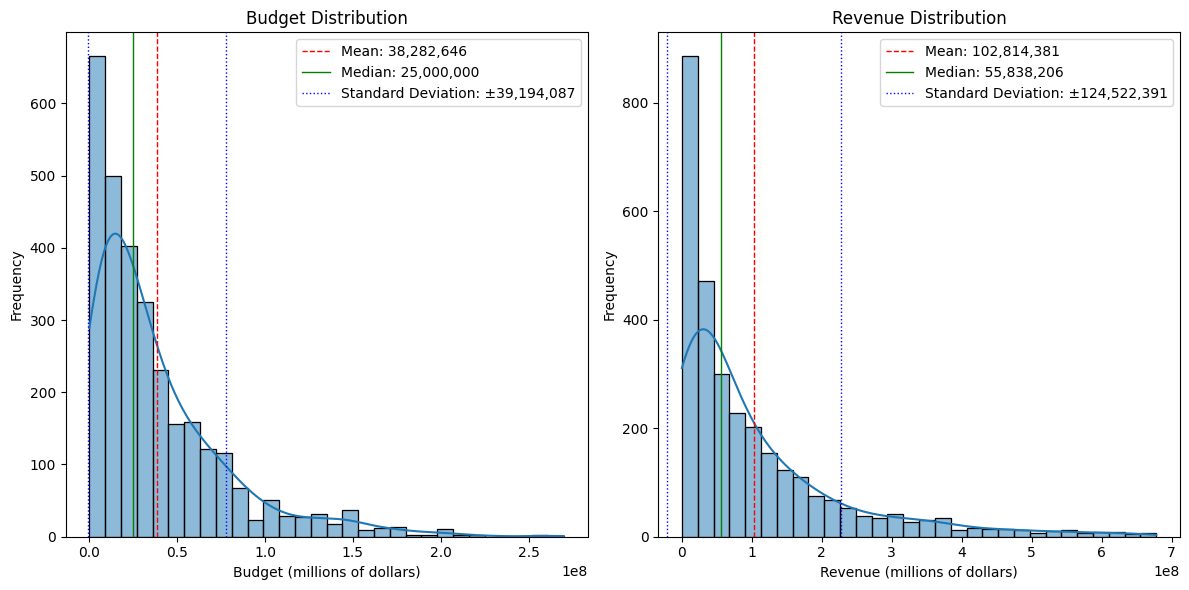

In [861]:
# Function to format descriptive statistics to add to plots
def add_stats_to_hist(ax, data, color='black'):
    mean = data.mean()
    median = data.median()
    std = data.std()
    ax.axvline(mean, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean:,.0f}')
    ax.axvline(median, color='green', linestyle='-', linewidth=1, label=f'Median: {median:,.0f}')
    ax.axvline(mean + std, color='blue', linestyle=':', linewidth=1, label=f'Standard Deviation: ±{std:,.0f}')
    ax.axvline(mean - std, color='blue', linestyle=':', linewidth=1)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Budget distribution
sns.histplot(all_movies_data['budget'], bins=30, ax=axes[0], kde=True, kde_kws={'bw_adjust': 1.5})
axes[0].set_title('Budget Distribution')
axes[0].set_xlabel('Budget (millions of dollars)')
axes[0].set_ylabel('Frequency')
add_stats_to_hist(axes[0], all_movies_data['budget'])

# Revenue distribution
sns.histplot(all_movies_data['revenue'], bins=30, ax=axes[1], kde=True, kde_kws={'bw_adjust': 1.5})
axes[1].set_title('Revenue Distribution')
axes[1].set_xlabel('Revenue (millions of dollars)')
axes[1].set_ylabel('Frequency')
add_stats_to_hist(axes[1], all_movies_data['revenue'])

plt.tight_layout()
plt.show()

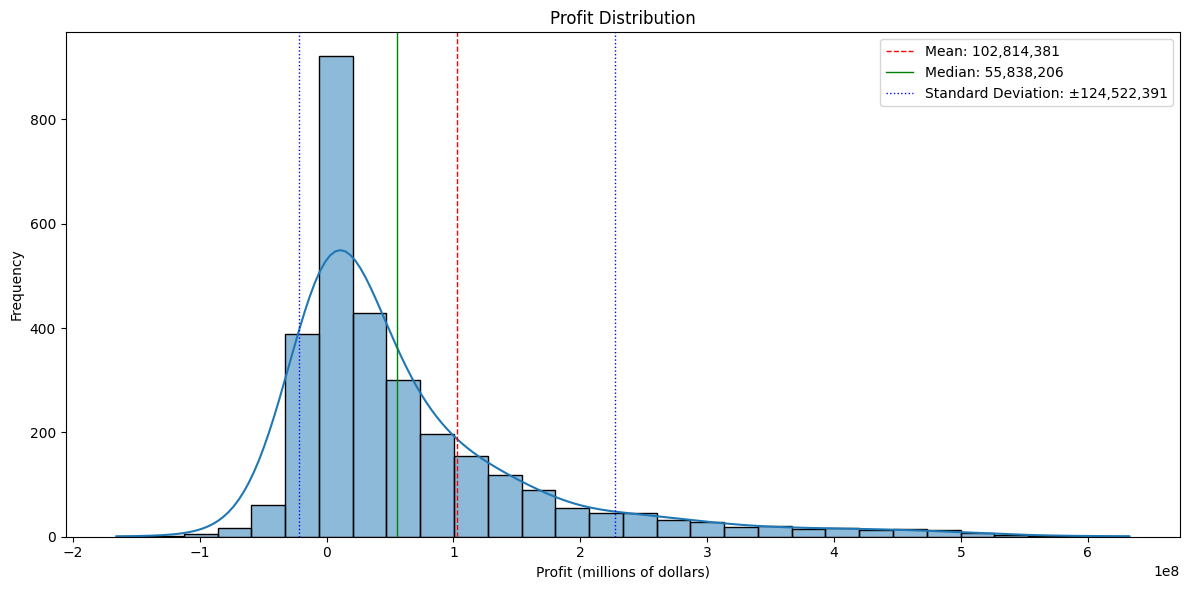

In [862]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

# Profit distribution
sns.histplot(all_movies_data['profit'], bins=30, ax=axes, kde=True, kde_kws={'bw_adjust': 1.5})
axes.set_title('Profit Distribution')
axes.set_xlabel('Profit (millions of dollars)')
axes.set_ylabel('Frequency')
add_stats_to_hist(axes, all_movies_data['revenue'])

plt.tight_layout()
plt.show()

### Popularity and Vote Average

Popularity is a measure of lifetime engagement for a movie from the TMDB website. You can read about all that does into it in the [TMDB docs](https://developer.themoviedb.org/docs/popularity-and-trending).

Vote average is a 0-10 star score based on users' votes.

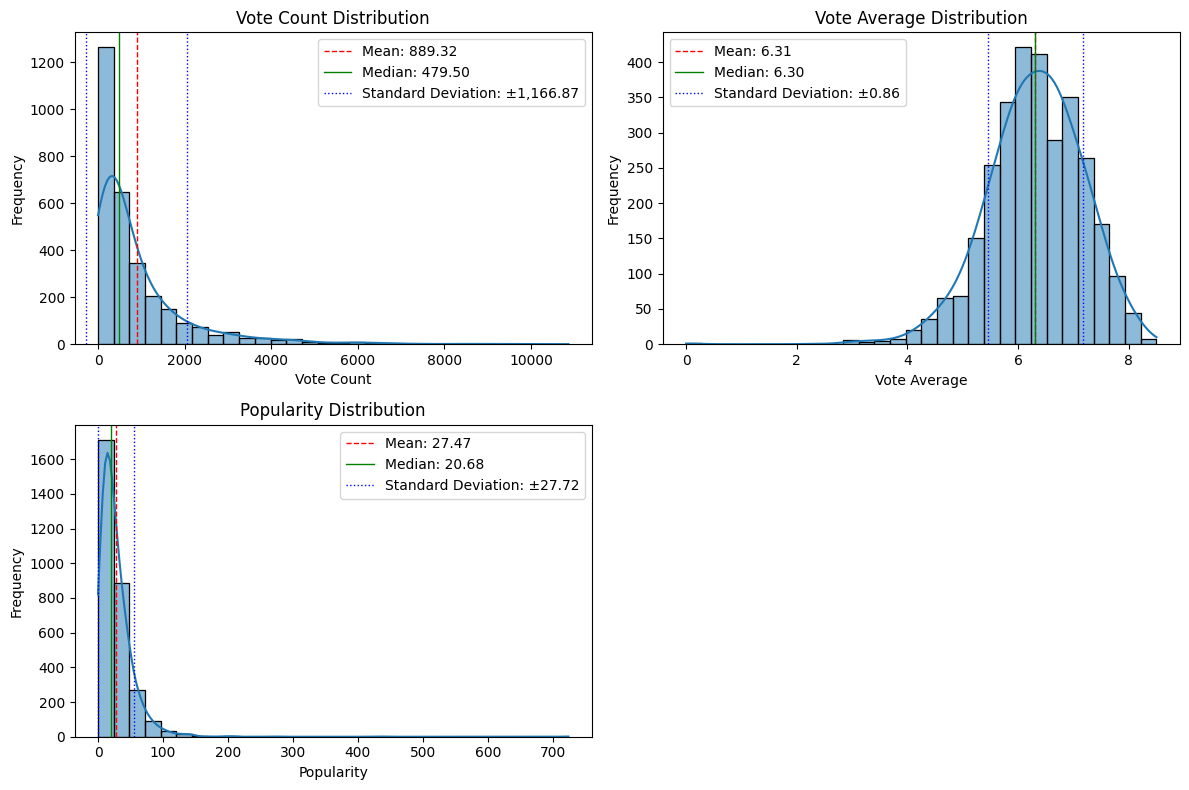

In [863]:
# Function to format descriptive statistics to add to plots, with different formatting for smaller values
def add_small_stats_to_hist(ax, data, color='black'):
    mean = data.mean()
    median = data.median()
    std = data.std()
    ax.axvline(mean, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean:,.2f}')
    ax.axvline(median, color='green', linestyle='-', linewidth=1, label=f'Median: {median:,.2f}')
    ax.axvline(mean + std, color='blue', linestyle=':', linewidth=1, label=f'Standard Deviation: ±{std:,.2f}')
    ax.axvline(mean - std, color='blue', linestyle=':', linewidth=1)
    ax.legend()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.delaxes(axes[1, 1])

# Popularity distribution
sns.histplot(all_movies_data['vote_count'], bins=30, ax=axes[0,0], kde=True, kde_kws={'bw_adjust': 1.5})
axes[0,0].set_title('Vote Count Distribution')
axes[0,0].set_xlabel('Vote Count')
axes[0,0].set_ylabel('Frequency')
add_small_stats_to_hist(axes[0,0], all_movies_data['vote_count'])

# Vote average distribution
sns.histplot(all_movies_data['vote_average'], bins=30, ax=axes[0,1], kde=True, kde_kws={'bw_adjust': 1.5})
axes[0,1].set_title('Vote Average Distribution')
axes[0,1].set_xlabel('Vote Average')
axes[0,1].set_ylabel('Frequency')
add_small_stats_to_hist(axes[0,1], all_movies_data['vote_average'])

# Popularity distribution
sns.histplot(all_movies_data['popularity'], bins=30, ax=axes[1,0], kde=True, kde_kws={'bw_adjust': 1.5})
axes[1,0].set_title('Popularity Distribution')
axes[1,0].set_xlabel('Popularity')
axes[1,0].set_ylabel('Frequency')
add_small_stats_to_hist(axes[1,0], all_movies_data['popularity'])

plt.tight_layout()
plt.show()

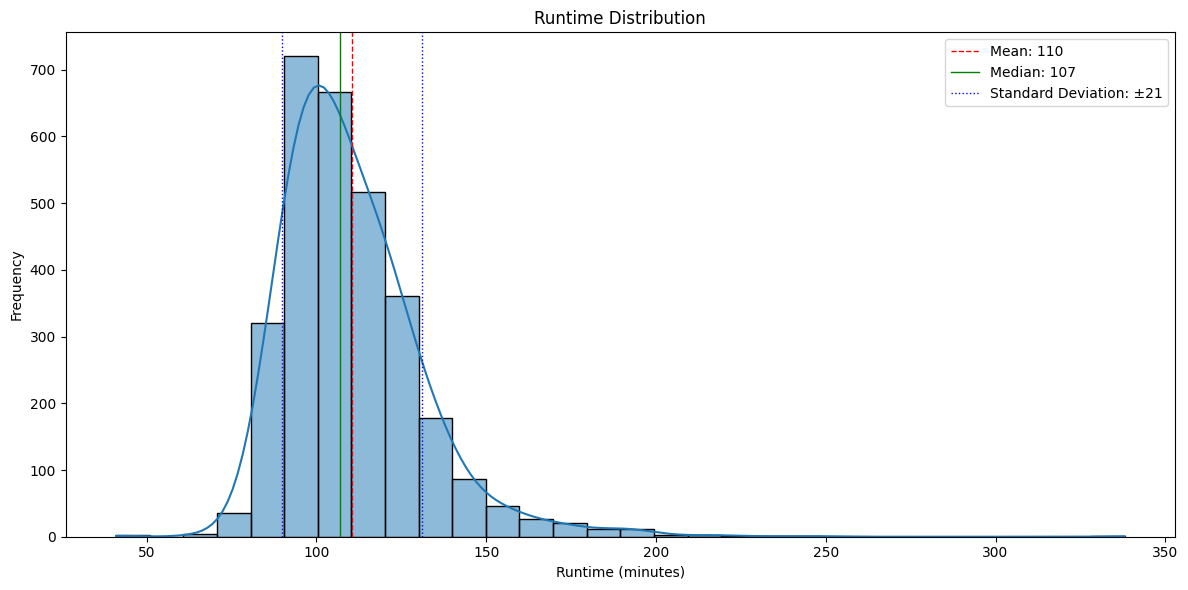

In [864]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

# Profit distribution
sns.histplot(all_movies_data['runtime'], bins=30, ax=axes, kde=True, kde_kws={'bw_adjust': 1.5})
axes.set_title('Runtime Distribution')
axes.set_xlabel('Runtime (minutes)')
axes.set_ylabel('Frequency')
add_stats_to_hist(axes, all_movies_data['runtime'])

plt.tight_layout()
plt.show()

Scatter plot of Budget vs Revenue by Primary genre

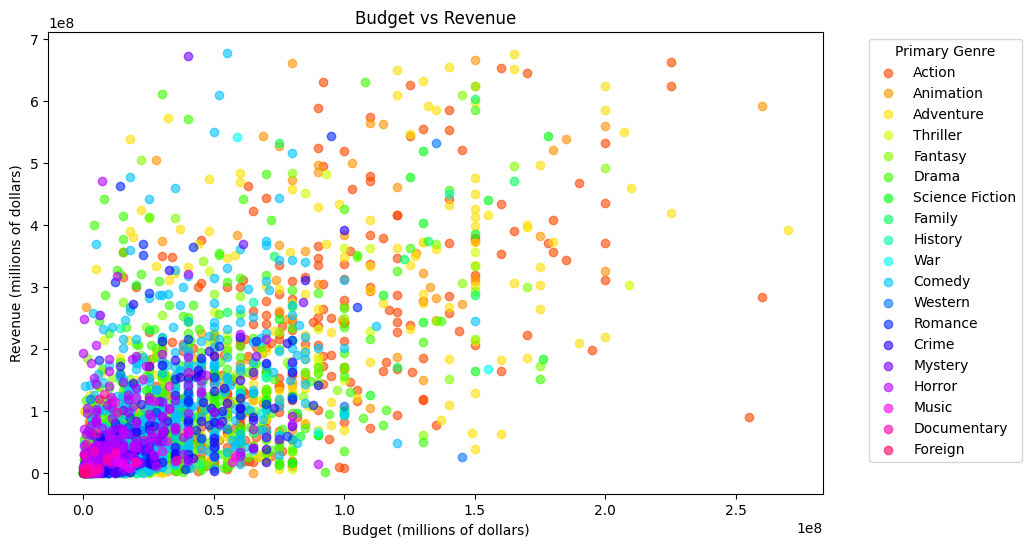

In [865]:
# Create a color palette
unique_genres = all_movies_data['primary_genre'].unique()
genre_palette = sns.color_palette('hsv', len(unique_genres))
genre_color_map = dict(zip(unique_genres, genre_palette))

# Create a scatter plot of budget vs revenue by genre
plt.figure(figsize=(10, 6))
for genre in unique_genres:
    subset = all_movies_data[all_movies_data['primary_genre'] == genre]
    plt.scatter(subset['budget'], subset['revenue'], label=genre, color=genre_color_map[genre], alpha=0.6)

    # Calculate the best fit line for each genre
    # m, b = np.polyfit(subset['budget'], subset['revenue'], 1)
    # plt.plot(subset['budget'], m * subset['budget'] + b, color=genre_color_map[genre], linewidth=1)

plt.title('Budget vs Revenue')
plt.xlabel('Budget (millions of dollars)')
plt.ylabel('Revenue (millions of dollars)')
plt.legend(title='Primary Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [866]:
# Correlations
all_movies_data[['budget', 'revenue', 'popularity', 'vote_average', 'runtime']].corr()

,budget,revenue,popularity,vote_average,runtime
budget,1.000000,0.657659,0.393830,-0.098031,0.165310
revenue,0.657659,1.000000,0.579159,0.153701,0.152927
popularity,0.393830,0.579159,1.000000,0.313190,0.168589
vote_average,-0.098031,0.153701,0.313190,1.000000,0.376703
runtime,0.165310,0.152927,0.168589,0.376703,1.000000


Side-by-side box plots of profit and profit_ratio by genre

/var/folders/q4/_1_vts6n2vg5rvqrn52fvfd00000gn/T/ipykernel_25654/2580683678.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='primary_genre', y='revenue', data=all_movies_data, palette=genre_color_map, ax=axes[0])
/var/folders/q4/_1_vts6n2vg5rvqrn52fvfd00000gn/T/ipykernel_25654/2580683678.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/var/folders/q4/_1_vts6n2vg5rvqrn52fvfd00000gn/T/ipykernel_25654/2580683678.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='primary_genre', y='budget', data=all_movies_data, palette=ge

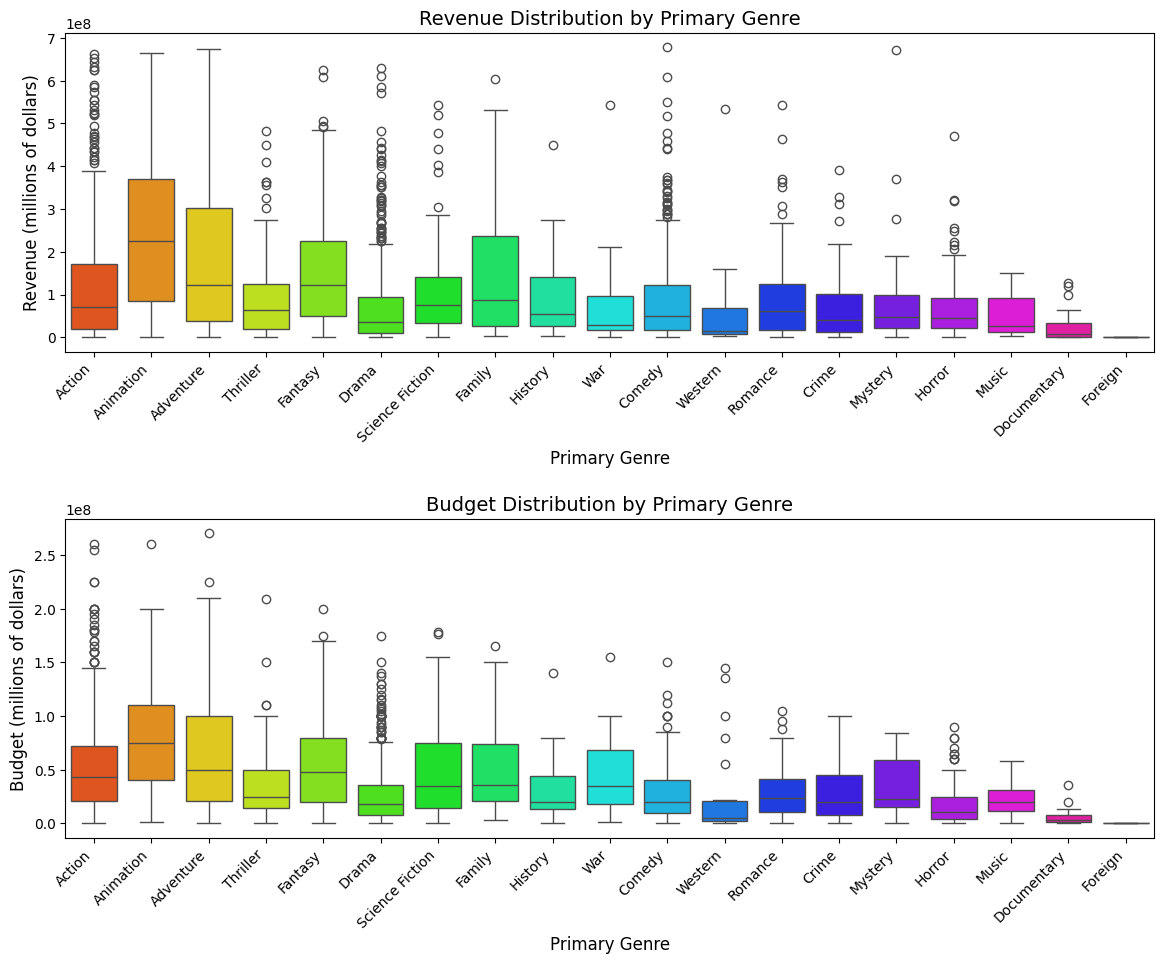

In [867]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

sns.boxplot(x='primary_genre', y='revenue', data=all_movies_data, palette=genre_color_map, ax=axes[0])
axes[0].set_title('Revenue Distribution by Primary Genre', fontsize=14)
axes[0].set_xlabel('Primary Genre', fontsize=12)
axes[0].set_ylabel('Revenue (millions of dollars)', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

sns.boxplot(x='primary_genre', y='budget', data=all_movies_data, palette=genre_color_map, ax=axes[1])
axes[1].set_title('Budget Distribution by Primary Genre', fontsize=14)
axes[1].set_xlabel('Primary Genre', fontsize=12)
axes[1].set_ylabel('Budget (millions of dollars)', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout(pad=2)
plt.show()

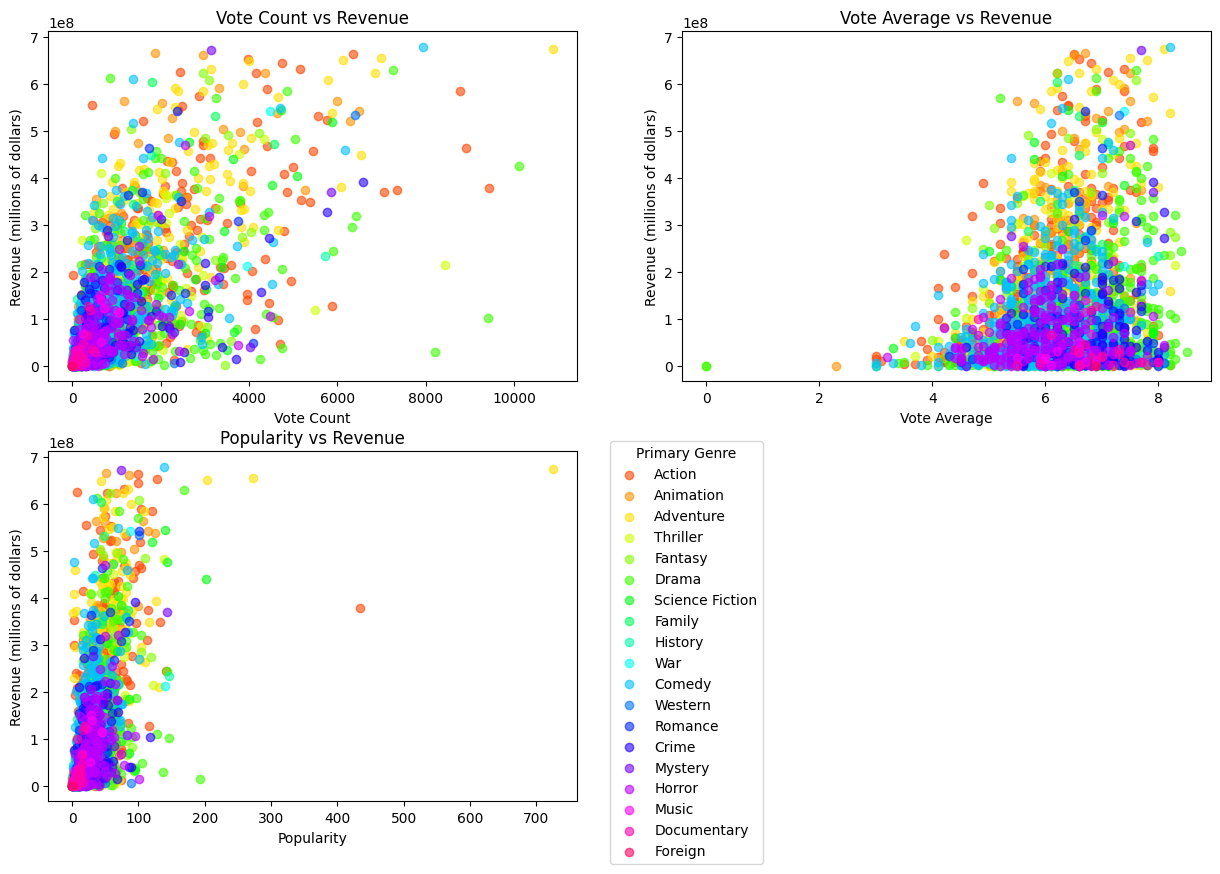

In [868]:
# Scatter plots for revenue vs popularity and vote_average
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.delaxes(axes[1, 1])

for genre in unique_genres:
    subset = all_movies_data[all_movies_data['primary_genre'] == genre]
    axes[0,0].scatter(subset['vote_count'], subset['revenue'], label=genre, color=genre_color_map[genre], alpha=0.6)
axes[0,0].set_title('Vote Count vs Revenue')
axes[0,0].set_xlabel('Vote Count')
axes[0,0].set_ylabel('Revenue (millions of dollars)')

for genre in unique_genres:
    subset = all_movies_data[all_movies_data['primary_genre'] == genre]
    axes[0,1].scatter(subset['vote_average'], subset['revenue'], label=genre, color=genre_color_map[genre], alpha=0.6)
axes[0,1].set_title('Vote Average vs Revenue')
axes[0,1].set_xlabel('Vote Average')
axes[0,1].set_ylabel('Revenue (millions of dollars)')

for genre in unique_genres:
    subset = all_movies_data[all_movies_data['primary_genre'] == genre]
    axes[1,0].scatter(subset['popularity'], subset['revenue'], label=genre, color=genre_color_map[genre], alpha=0.6)
axes[1,0].set_title('Popularity vs Revenue')
axes[1,0].set_xlabel('Popularity')
axes[1,0].set_ylabel('Revenue (millions of dollars)')
axes[1,0].legend(title='Primary Genre', bbox_to_anchor=(1.05, 1.05), loc='upper left')

plt.show()

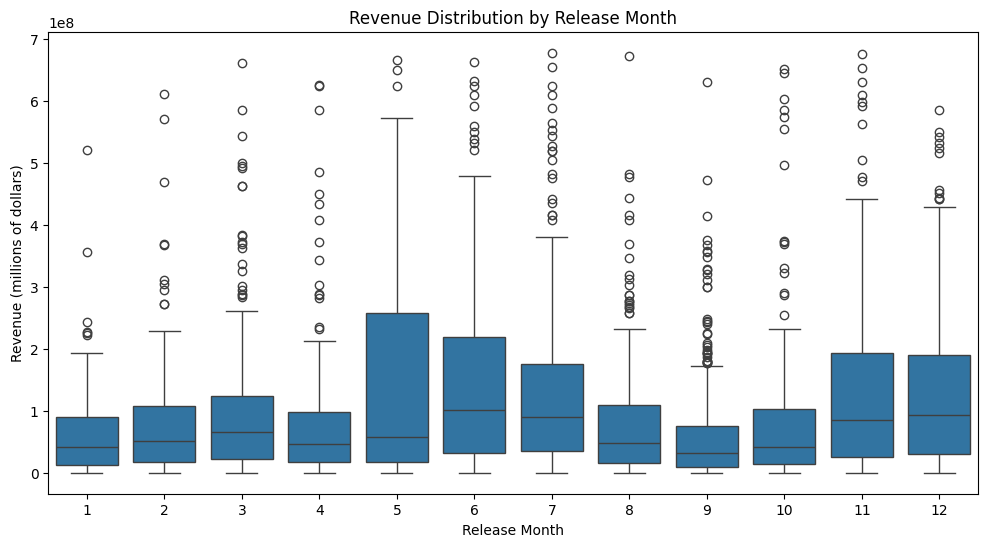

In [869]:
# Revenue by release month
plt.figure(figsize=(12, 6))
sns.boxplot(x='release_month', y='revenue', data=all_movies_data)
plt.title('Revenue Distribution by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Revenue (millions of dollars)')
plt.show()

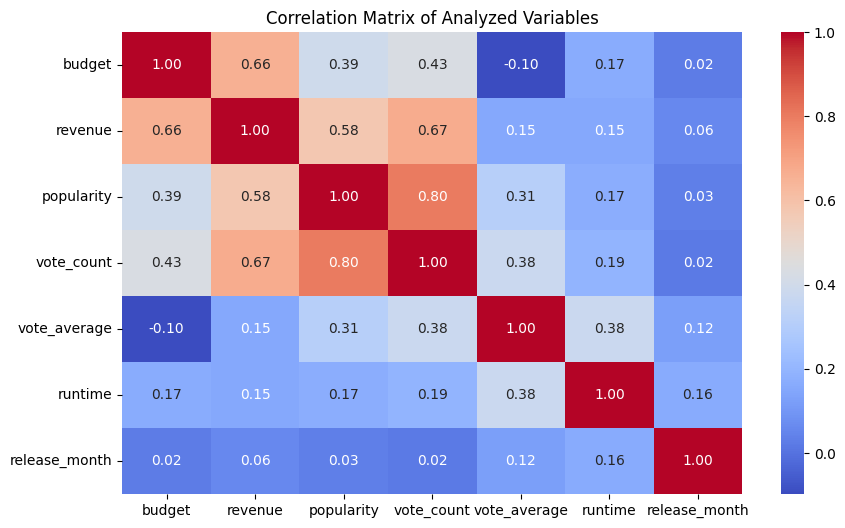

In [870]:
# Create a correlation matrix to summarize the relationships between revenue and the variables
correlation_matrix = all_movies_data[['budget', 'revenue', 'popularity', 'vote_count', 'vote_average', 'runtime', 'release_month']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Analyzed Variables')
plt.show()

$H_0:$ There is no significant difference in revenue between high and low budget movies

$H_a:$ There is a significant difference in revenue between high and low budget movies

In [871]:
# Split movies into high and low budget by the median
median_budget = all_movies_data['budget'].median()
low_budget_movie_revenue = all_movies_data[all_movies_data['budget'] <= median_budget]['revenue']
high_budget_movie_revenue = all_movies_data[all_movies_data['budget'] > median_budget]['revenue']

budget_t_stat, budget_p_value = ttest_ind(low_budget_movie_revenue, high_budget_movie_revenue, equal_var=False)
print('T stat and P value for budget: {}, {}'.format(budget_t_stat, budget_p_value))

T stat and P value for budget: -27.13327992060762, 8.012340059963267e-140


$H_0:$ There is no significant difference in revenue between movies with high and low popularity

$H_a:$ There is a significant difference in revenue between movies with high and low popularity

In [872]:
median_popularity = all_movies_data['popularity'].median()
low_pop_movie_revenue = all_movies_data[all_movies_data['popularity'] <= median_popularity]['revenue']
high_pop_movie_revenue = all_movies_data[all_movies_data['popularity'] > median_popularity]['revenue']

pop_t_stat, pop_p_value = ttest_ind(low_pop_movie_revenue, high_pop_movie_revenue, equal_var=False)
print('T stat and P value for popularity: {}, {}'.format(pop_t_stat, pop_p_value))

T stat and P value for popularity: -29.569695280503122, 5.159601737362092e-160


$H_0:$ There is no significant difference in revenue between movies with high and low vote counts

$H_a:$ There is a significant difference in revenue between movies with high and low vote counts

In [873]:
median_vote_count = all_movies_data['vote_count'].median()
low_vc_movie_revenue = all_movies_data[all_movies_data['vote_count'] <= median_vote_count]['revenue']
high_vc_movie_revenue = all_movies_data[all_movies_data['vote_count'] > median_vote_count]['revenue']

vc_t_stat, vc_p_value = ttest_ind(low_vc_movie_revenue, high_vc_movie_revenue, equal_var=False)
print('T stat and P value for vote_count: {}, {}'.format(vc_t_stat, vc_p_value))

T stat and P value for vote_count: -33.20824438890315, 3.791452360728696e-189


In [874]:
median_vote_average = all_movies_data['vote_average'].median()
low_va_movie_revenue = all_movies_data[all_movies_data['vote_average'] <= median_vote_average]['revenue']
high_va_movie_revenue = all_movies_data[all_movies_data['vote_average'] > median_vote_average]['revenue']

va_t_stat, va_p_value = ttest_ind(low_va_movie_revenue, high_va_movie_revenue, equal_var=False)
print('T stat and P value for vote_average: {}, {}'.format(va_t_stat, va_p_value))

T stat and P value for vote_average: -5.238644242473006, 1.7389763251601986e-07


In [875]:
median_runtime = all_movies_data['runtime'].median()
low_rt_movie_revenue = all_movies_data[all_movies_data['runtime'] <= median_runtime]['revenue']
high_rt_movie_revenue = all_movies_data[all_movies_data['runtime'] > median_runtime]['revenue']

rt_t_stat, rt_p_value = ttest_ind(low_rt_movie_revenue, high_rt_movie_revenue, equal_var=False)
print('T stat and P value for runtime: {}, {}'.format(rt_t_stat, rt_p_value))

T stat and P value for runtime: -8.228337758449312, 2.8456939538449477e-16


$H_0:$ The mean revenue is the same for movies release in different months

$H_a:$ The mean revenue is different for movies release in different months

In [876]:
revenue_by_month = [all_movies_data[all_movies_data['release_month'] == month]['revenue'] for month in range(1, 13)]
rm_f_stat, rm_p_value = f_oneway(*revenue_by_month)
print('F stat and P value for release month: {}, {}'.format(rm_f_stat, rm_p_value))

F stat and P value for release month: 19.82653167358755, 4.142338937821551e-39


In [877]:
all_genre_ids = all_movies_data['primary_genre_id'].unique()
revenue_by_genre = [all_movies_data[all_movies_data['primary_genre_id'] == primary_genre_id]['revenue'] for primary_genre_id in all_genre_ids]
genre_f_stat, genre_p_value = f_oneway(*revenue_by_genre)
print('F stat and P value for primary genre: {}, {}'.format(genre_f_stat, genre_p_value))

F stat and P value for primary genre: 21.861814272747555, 1.1429824432697361e-67


#### Models

In [878]:
mlr_formula = 'revenue ~ budget + popularity + vote_count + vote_average + runtime'
mlr_model = smf.ols(formula=mlr_formula, data=all_movies_data).fit()

mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     989.4
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        06:15:37   Log-Likelihood:                -59031.
No. Observations:                3016   AIC:                         1.181e+05
Df Residuals:                    3010   BIC:                         1.181e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.126e+07   1.21e+07     -0.932      0.352    -3.5e+07    1.24e+07
budget           1.4643      0.043     34.220      0.000       1.380       1.548
popularity    2.138e+05   8.44e+04      2.531      0.011    4.82e+04    3.79e+05
vote_count    4.595e+04   2134.717     21.526      0.000    4.18e+04    5.01e+04
vote_average  4.465e+06      2e+06      2.238      0.025    5.53e+05    8.38e+06
runtime      -1.529e+05   7.52e+04     -2.033      0.042      -3e+05   -5419.065
==============================================================================
Omnibus:                      871.268   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5435.259
Skew:                           1.220   Prob(JB):                         0.00
Kurtosis:                       9.107   Cond. No.                     4.78e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

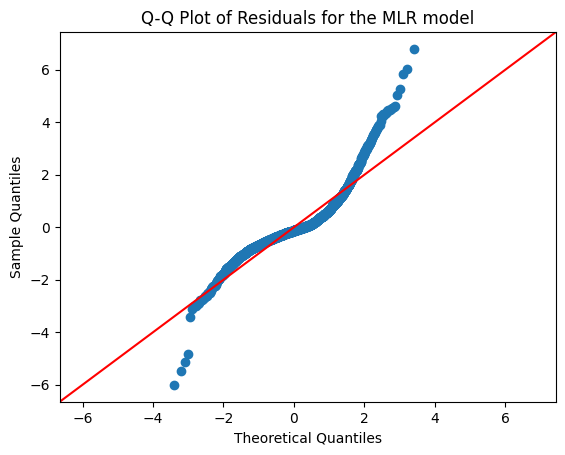

In [879]:
# Check residuals of the model
residuals = mlr_model.resid

sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals for the MLR model')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

In [880]:
all_movies_data['log_revenue'] = np.log(all_movies_data['revenue'])
all_movies_data['log_budget'] = np.log(all_movies_data['budget'])
all_movies_data['log_popularity'] = np.log(all_movies_data['popularity'])
all_movies_data['log_vote_count'] = np.log1p(all_movies_data['vote_count'])

transformed_mlr_formula = 'log_revenue ~ log_budget + log_vote_count'
transformed_mlr_model = smf.ols(formula=transformed_mlr_formula, data=all_movies_data).fit()

transformed_mlr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     2032.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        06:15:37   Log-Likelihood:                -5025.2
No. Observations:                3016   AIC:                         1.006e+04
Df Residuals:                    3013   BIC:                         1.007e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.1087      0.248     16.571      0.000       3.623       4.595
log_budget         0.5493      0.016     34.541      0.000       0.518       0.581
log_vote_count     0.6861      0.019     36.177      0.000       0.649       0.723
==============================================================================
Omnibus:                     1955.226   Durbin-Watson:                   1.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58232.234
Skew:                          -2.608   Prob(JB):                         0.00
Kurtosis:                      23.885   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [881]:
def test_model(test_data, training_model):
    # Predict the log revenue on the remaining 30% that the model hasn't seen before
    test_data['predicted_log_revenue'] = training_model.predict(test_data)

    actual = test_data['log_revenue']
    predicted = test_data['predicted_log_revenue']

    rmsle = np.sqrt(np.mean((np.log1p(actual) - np.log1p(predicted)) ** 2))
    mpe = np.mean((actual - predicted) / actual) * 100
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print('Root mean squared logarithmic error: {}'.format(rmsle))
    print('Mean percentage error: {}'.format(mpe))
    print('Mean absolute percentage error: {}'.format(mape))

# Test the model by training with 70% of data and testing the remaining 30%
train_data, test_data = train_test_split(all_movies_data, test_size=0.3, random_state=42)

# New model fit on 70% of the dataset
training_model = smf.ols(formula=transformed_mlr_formula, data=train_data).fit()

test_model(test_data, training_model)

Root mean squared logarithmic error: 0.07539804463177692
Mean percentage error: -0.5406533281960225
Mean absolute percentage error: 5.1309899408555255


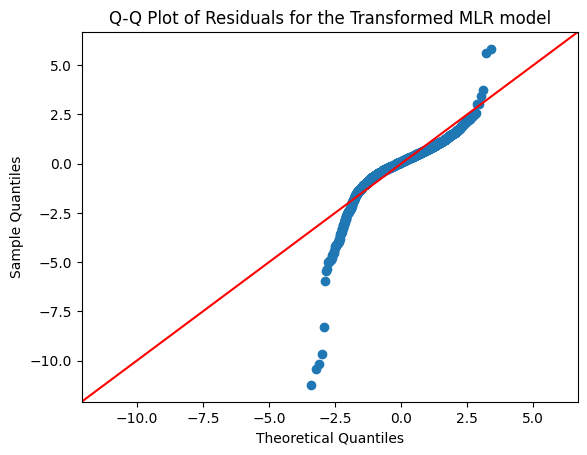

In [882]:
# Check residuals of the model
transformed_residuals = transformed_mlr_model.resid

sm.qqplot(transformed_residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals for the Transformed MLR model')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

In [883]:
# Try a glm with the gamma family
glm_formula = 'log_revenue ~ log_budget + log_vote_count'
glm_model = smf.glm(formula=glm_formula, data=all_movies_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

glm_model.summary()


/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            log_revenue   No. Observations:                 3016
Model:                            GLM   Df Residuals:                     3013
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                       0.0075398
Method:                          IRLS   Log-Likelihood:                -6228.6
Date:                Thu, 10 Oct 2024   Deviance:                       33.527
Time:                        06:15:37   Pearson chi2:                     22.7
No. Iterations:                    12   Pseudo R-squ. (CS):             0.6557
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.9865      0.017    118.212      0.000       1.954       2.019
log_budget         0.0378      0.001     35.037      0.000       0.036       0.040
log_vote_count     0.0391      0.001     30.420      0.000       0.037       0.042
==================================================================================
"""

In [884]:
training_model = smf.glm(formula=glm_formula, data=train_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

test_model(test_data, training_model)

Root mean squared logarithmic error: 0.07680331587247342
Mean percentage error: -0.5010009398687274
Mean absolute percentage error: 5.297641332961591


/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [885]:
# Add categorical variables to the glm
glm_formula_w_categories = 'log_revenue ~ log_budget + log_vote_count + C(release_month) + C(primary_genre)'
glm_model_w_categories = smf.glm(formula=glm_formula_w_categories, data=all_movies_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

glm_model_w_categories.summary()

/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            log_revenue   No. Observations:                 3016
Model:                            GLM   Df Residuals:                     2984
Model Family:                   Gamma   Df Model:                           31
Link Function:                    log   Scale:                       0.0074807
Method:                          IRLS   Log-Likelihood:                -6178.8
Date:                Thu, 10 Oct 2024   Deviance:                       32.698
Time:                        06:15:37   Pearson chi2:                     22.3
No. Iterations:                    11   Pseudo R-squ. (CS):             0.6709
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.9394      0.020     98.337      0.000       1.901       1.978
C(release_month)[T.2]                   0.0137      0.009      1.554      0.120      -0.004       0.031
C(release_month)[T.3]                   0.0148      0.009      1.700      0.089      -0.002       0.032
C(release_month)[T.4]                   0.0123      0.009      1.380      0.168      -0.005       0.030
C(release_month)[T.5]                   0.0099      0.009      1.125      0.261      -0.007       0.027
C(release_month)[T.6]                   0.0201      0.008      2.374      0.018       0.004       0.037
C(release_month)[T.7]                   0.0199      0.009      2.325      0.020       0.003       0.037
C(release_month)[T.8]                   0.0091      0.008      1.089      0.276      -0.007       0.026
C(release_month)[T.9]                  -0.0031      0.008     -0.385      0.701      -0.019       0.013
C(release_month)[T.10]                  0.0054      0.008      0.647      0.518      -0.011       0.022
C(release_month)[T.11]                  0.0212      0.009      2.454      0.014       0.004       0.038
C(release_month)[T.12]                  0.0132      0.008      1.616      0.106      -0.003       0.029
C(primary_genre)[T.Adventure]           0.0031      0.007      0.469      0.639      -0.010       0.016
C(primary_genre)[T.Animation]           0.0103      0.010      1.007      0.314      -0.010       0.030
C(primary_genre)[T.Comedy]              0.0197      0.005      3.778      0.000       0.009       0.030
C(primary_genre)[T.Crime]              9.6e-05      0.008      0.012      0.991      -0.016       0.016
C(primary_genre)[T.Documentary]         0.0557      0.018      3.093      0.002       0.020       0.091
C(primary_genre)[T.Drama]               0.0103      0.005      2.005      0.045       0.000       0.020
C(primary_genre)[T.Family]              0.0236      0.016      1.493      0.135      -0.007       0.055
C(primary_genre)[T.Fantasy]            -0.0116      0.010     -1.156      0.248      -0.031       0.008
C(primary_genre)[T.Foreign]            -0.0676      0.087     -0.777      0.437      -0.238       0.103
C(primary_genre)[T.History]             0.0476      0.021      2.228      0.026       0.006       0.089
C(primary_genre)[T.Horror]              0.0404      0.007      5.426      0.000       0.026       0.055
C(primary_genre)[T.Music]               0.0464      0.020      2.289      0.022       0.007       0.086
C(primary_genre)[T.Mystery]            -0.0204      0.017     -1.172      0.241      -0.055       0.014
C(primary_genre)[T.Romance]             0.0003      0.011      0.023      0.981      -0.022       0.022
C(primary_genre)[T.Science Fiction]    -0.0157      0.011     -1.40

In [886]:
training_model = smf.glm(formula=glm_formula_w_categories, data=train_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

test_model(test_data, training_model)

/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Root mean squared logarithmic error: 0.07641536230455151
Mean percentage error: -0.42990031933524897
Mean absolute percentage error: 5.319340896331879


In [887]:
# Use interaction between release month and genre
glm_formula_w_int = 'log_revenue ~ log_budget + log_vote_count + C(release_month) * C(primary_genre)'
glm_model_w_int = smf.glm(formula=glm_formula_w_int, data=all_movies_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

glm_model_w_int.summary()

/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            log_revenue   No. Observations:                 3016
Model:                            GLM   Df Residuals:                     2811
Model Family:                   Gamma   Df Model:                          204
Link Function:                    log   Scale:                       0.0076081
Method:                          IRLS   Log-Likelihood:                -6016.8
Date:                Thu, 10 Oct 2024   Deviance:                       30.401
Time:                        06:15:41   Pearson chi2:                     21.4
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6966
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      1.9313      0.024     79.809      0.000       1.884       1.979
C(release_month)[T.2]                                          0.0084      0.020      0.413      0.679      -0.032       0.048
C(release_month)[T.3]                                       8.443e-05      0.020      0.004      0.997      -0.039       0.039
C(release_month)[T.4]                                          0.0068      0.019      0.351      0.726      -0.031       0.045
C(release_month)[T.5]                                         -0.0028      0.019     -0.143      0.886      -0.041       0.035
C(release_month)[T.6]                                          0.0112      0.018      0.609      0.543      -0.025       0.047
C(release_month)[T.7]                                          0.0036      0.019      0.189      0.850      -0.034       0.041
C(release_month)[T.8]                                          0.0026      0.018      0.141      0.888      -0.034       0.039
C(release_month)[T.9]                                         -0.0075      0.019     -0.398      0.690      -0.044       0.029
C(release_month)[T.10]                                        -0.0015      0.021     -0.073      0.942      -0.042       0.039
C(release_month)[T.11]                                         0.0198      0.021      0.958      0.338      -0.021       0.060
C(release_month)[T.12]                                         0.0120      0.021      0.583      0.560      -0.028       0.052
C(primary_genre)[T.Adventure]                                  0.0103      0.042      0.247      0.805      -0.071       0.092
C(primary_genre)[T.Animation]                                  0.0172      0.011      1.556      0.120      -0.004       0.039
C(primary_genre)[T.Comedy]                                     0.0029      0.020      0.141      0.888      -0.037       0.043
C(primary_genre)[T.Crime]                                     -0.0239      0.028     -0.847      0.397      -0.079       0.031
C(primary_genre)[T.Documentary]                                0.1715      0.053      3.261      0.001       0.068       0.275
C(primary_genre)[T.Drama]                                     -0.0276      0.020     -1.364      0.172      -0.067       0.012
C(primary_genre)[T.Family]                                     0.0230      0.017      1.383      0.167      -0.010       0.056
C(primary_genre)[T.Fantasy]                                   -0.0411      0.034     -1.204      0.229      -0.108       0.026
C(primary_genre)[T.Foreign]                                   -0.0345      0.044     -0.778      0.437      -0.121       0.052
C(primary_genre)[T.History]        

In [888]:
training_model = smf.glm(formula=glm_formula_w_int, data=train_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

test_model(test_data, training_model)

/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Root mean squared logarithmic error: 0.08079056878767713
Mean percentage error: -0.4959891703725786
Mean absolute percentage error: 5.691158624056576


In [889]:
# Add budget to the interaction term
glm_formula_three_way_interaction = 'log_revenue ~ log_budget * C(release_month) * C(primary_genre) + log_vote_count'
glm_model_three_way_interaction = smf.glm(formula=glm_formula_three_way_interaction, data=all_movies_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

glm_model_three_way_interaction.summary()

/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            log_revenue   No. Observations:                 3016
Model:                            GLM   Df Residuals:                     2638
Model Family:                   Gamma   Df Model:                          377
Link Function:                    log   Scale:                       0.0063854
Method:                          IRLS   Log-Likelihood:                -5423.7
Date:                Thu, 10 Oct 2024   Deviance:                       21.319
Time:                        06:15:47   Pearson chi2:                     16.8
No. Iterations:                    21   Pseudo R-squ. (CS):             0.8493
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 2.0397      0.265      7.696      0.000       1.520       2.559
C(release_month)[T.2]                                                     0.2439      0.344      0.709      0.478      -0.431       0.919
C(release_month)[T.3]                                                     0.2094      0.445      0.470      0.638      -0.663       1.082
C(release_month)[T.4]                                                     0.1996      0.303      0.660      0.509      -0.394       0.793
C(release_month)[T.5]                                                     0.0208      0.309      0.068      0.946      -0.584       0.626
C(release_month)[T.6]                                                     0.1825      0.315      0.579      0.562      -0.435       0.800
C(release_month)[T.7]                                                     0.3321      0.348      0.954      0.340      -0.350       1.014
C(release_month)[T.8]                                                     0.0968      0.319      0.304      0.761      -0.528       0.722
C(release_month)[T.9]                                                    -0.0799      0.311     -0.257      0.797      -0.689       0.529
C(release_month)[T.10]                                                    0.0927      0.317      0.292      0.770      -0.529       0.715
C(release_month)[T.11]                                                    0.2386      0.351      0.679      0.497      -0.450       0.927
C(release_month)[T.12]                                                    0.2526      0.371      0.681      0.496      -0.474       0.979
C(primary_genre)[T.Adventure]                                            -0.0516      2.080     -0.025      0.980      -4.129       4.026
C(primary_genre)[T.Animation]                                            -0.2062      0.300     -0.687      0.492      -0.795       0.382
C(primary_genre)[T.Comedy]                                                0.2213      0.358      0.618      0.536      -0.480       0.923
C(primary_genre)[T.Crime]                                                -0.0648      0.363     -0.178      0.858      -0.776       0.646
C(primary_genre)[T.Documentary]                                           0.3284      0.417      0.788      0.431      -0.489       1.146
C(primary_genre)[T.Drama]                                                -0.2786      0.312     -0.894      0.371      -0.889       0.332
C(primary_genre)[T.Family]                                                0.6873      7.800      0.088      0.930     -14.601      15.976
C(primary_genre)[T.Fantasy]                    

In [890]:
training_model = smf.glm(formula=glm_formula_three_way_interaction, data=train_data, family=sm.families.Gamma(link=sm.families.links.log())).fit()

test_model(test_data, training_model)

/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Root mean squared logarithmic error: 0.14957971255067046
Mean percentage error: -1.952436983605467
Mean absolute percentage error: 7.226428263939868
